In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Paramètres
latent_dim = 100
img_shape = (28, 28, 1)
batch_size = 128
epochs = 10000
sample_interval = 1000

In [ ]:
# Construction du générateur et discriminateur
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
    model.add(layers.Reshape(img_shape))
    return model


def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
# Charger les données MNIST
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Créer et compiler le discriminateur
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

# Créer le générateur
generator = build_generator()
# Le générateur prend du bruit et génère des images
z = layers.Input(shape=(latent_dim,))
img = generator(z)

# Pour le modèle combiné, seul le générateur est entraîné
discriminator.trainable = False

# Le discriminateur prend les images générées et essaie de les classifier comme réelles
validity = discriminator(img)

# Modèle combiné (empiler le générateur et le discriminateur)
combined = tf.keras.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

# Entraînement du GAN
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [ ]:
# Entraînement du GAN
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

2/2 [==============================] - 0s 8ms/step
0 [D loss: 0.3637353926897049, acc.: 86.71875%] [G loss: 0.7310161590576172]
1/1 [==============================] - 0s 21ms/step


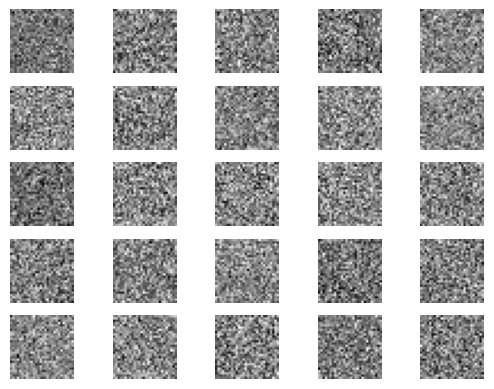

2/2 [==============================] - 0s 8ms/step
1000 [D loss: 0.5639654099941254, acc.: 85.15625%] [G loss: 0.9840215444564819]
1/1 [==============================] - 0s 23ms/step


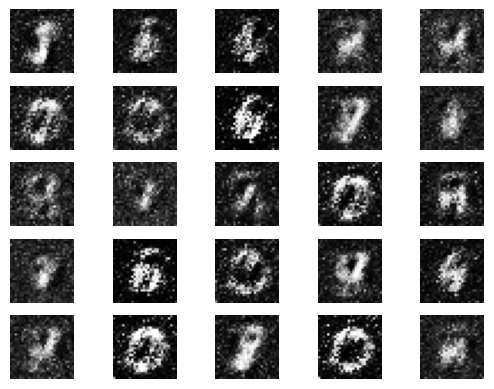

2/2 [==============================] - 0s 17ms/step
2000 [D loss: 0.5626245737075806, acc.: 67.96875%] [G loss: 1.063933253288269]
1/1 [==============================] - 0s 42ms/step


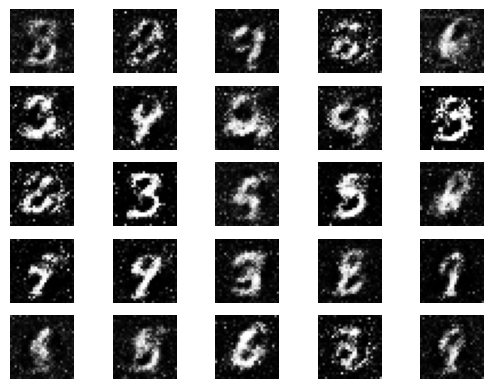

2/2 [==============================] - 0s 11ms/step
3000 [D loss: 0.6334609091281891, acc.: 67.1875%] [G loss: 0.9056975245475769]
1/1 [==============================] - 0s 22ms/step


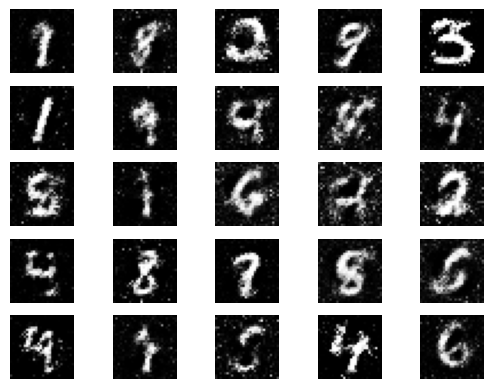

2/2 [==============================] - 0s 12ms/step
4000 [D loss: 0.670091450214386, acc.: 62.5%] [G loss: 0.8879057168960571]
1/1 [==============================] - 0s 22ms/step


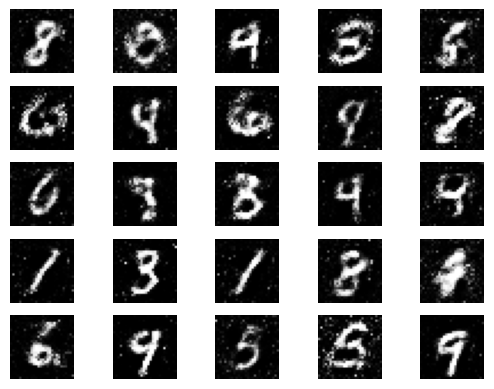

2/2 [==============================] - 0s 10ms/step
5000 [D loss: 0.6809135377407074, acc.: 57.03125%] [G loss: 0.8797031044960022]
1/1 [==============================] - 0s 22ms/step


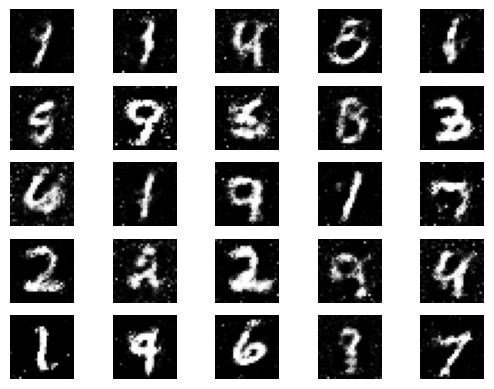

2/2 [==============================] - 0s 12ms/step
6000 [D loss: 0.7137153148651123, acc.: 50.78125%] [G loss: 0.8344827890396118]
1/1 [==============================] - 0s 29ms/step


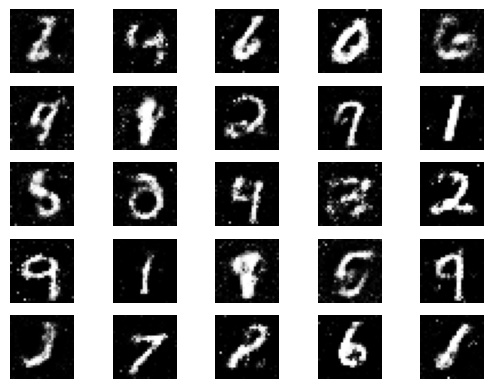

2/2 [==============================] - 0s 14ms/step
7000 [D loss: 0.6943196654319763, acc.: 53.125%] [G loss: 0.8015742301940918]
1/1 [==============================] - 0s 34ms/step


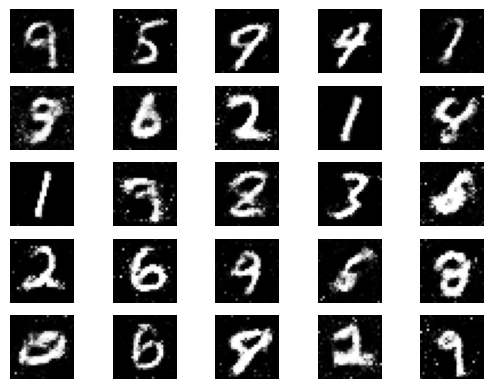

2/2 [==============================] - 0s 11ms/step
8000 [D loss: 0.7029114961624146, acc.: 48.4375%] [G loss: 0.7927924990653992]
1/1 [==============================] - 0s 25ms/step


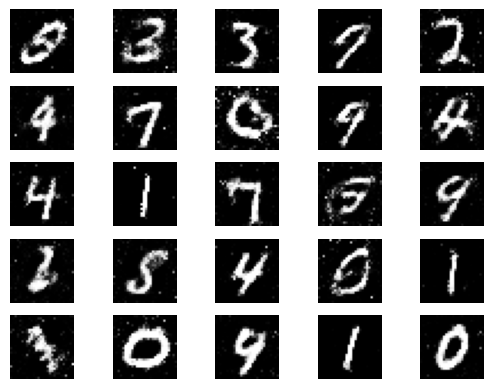

2/2 [==============================] - 0s 11ms/step
9000 [D loss: 0.6971682906150818, acc.: 53.125%] [G loss: 0.8042222857475281]
1/1 [==============================] - 0s 36ms/step


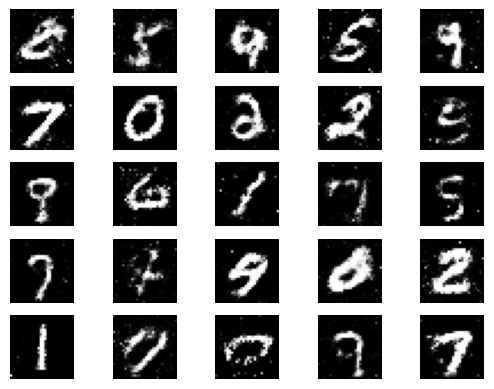

2/2 [==============================] - 0s 10ms/step


In [ ]:
for epoch in range(epochs):
    # Entraînement du discriminateur
    idx = np.random.randint(0, X_train.shape[0], batch_size // 2)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size // 2, latent_dim))
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, valid[:batch_size // 2])
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake[:batch_size // 2])
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Entraînement du générateur
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, valid)

    # Affichage des progrès
    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")
        sample_images(epoch)